### 1. 이 데이터는 믿을만할까?
- 1. 결측, 이상치, 편향을 점검하고 처리 기준을 제시
- 2. MedHouseValue가 0이거나 극단값인지, Medlnc/HouseAge/AveRooms 등 주요 변수의 범위가 현실적인지 확인
- 3. 1940년 이전 건축 주택이 52로 코딩되는 이유를 이해하고, 분석에 미칠 영향을 검토
- 4. 전처리 전,후가 어떻게 달라졌는지 한눈에 비교하는 표나 요약을 만듦
- 5. 단위, 해석 주의: MedHouseValue는 실제 달러 단위입니다. 1990년 명목가를 참고해 현실성을 평가하세요.

In [2]:
from hossam import load_data
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
from pandas import DataFrame

import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr

from itertools import combinations

In [3]:
my_dpi = 200
font_path = "../data_visualization/NotoSansKR-Regular.ttf"
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = "Noto Sans KR"
my_theme = "dark"

sb.set_theme(style=my_theme)
plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [4]:
origin = load_data('california_housing')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기 : {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 데이터 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/kaggle/california_housing.xlsx
[desc] 1990년 미국 인구조사(Census)를 기반으로 캘리포니아 각 지역의 인구·주택·소득 특성과 주택 중위가격을 담아, 회귀 분석과 머신러닝 모델 실습에 널리 사용되는 대표적인 주택 가격 데이터 (출처: https://www.kaggle.com/datasets/camnugent/california-housing-prices)

field               description
------------------  ------------------------------------------------------------------------------
longitude           경도(Longitude). 서경(–값) 기준.
latitude            위도(Latitude). 북위(+) 기준.
housing_median_age  해당 구역(블록 그룹)의 주택 중위 연령(년).
total_rooms         구역 내 모든 주택의 총 방(room) 수 합계.
total_bedrooms      구역 내 모든 주택의 총 침실(bedroom) 수 합계.
population          구역의 전체 인구 수.
households          구역의 전체 “가구 수”(living units).
median_income       구역의 중위 소득(median income), 단위는 약 1 = $10,000 수준.
median_house_value  주택 중위가격(달러). 회귀의 목표변수(타깃).
ocean_proximity     해안과의 거리/접근성 범주: <1H OCEAN, INLAND, NEAR BAY, NEAR OCEAN, ISLAND 등.


===== 데이터 크기 확인 =====
데이터셋 크기 : (20640, 10)
열 개수: 10
행 개수: 20640

===== 데이터 타입 확인 =====
<c

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,NEAR BAY


결측치 확인

In [5]:
origin.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

total_bedrooms 변수에 전체 건수 20640중 결측치 207건 발견 (1퍼센트에 해당 - 삭제해도 이상 없을듯?)

In [6]:
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  int64  
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


이상치 탐색 (MedHouseValue가 0인지, 극단값인지, 주요 변수의 범위가 현실적인지)

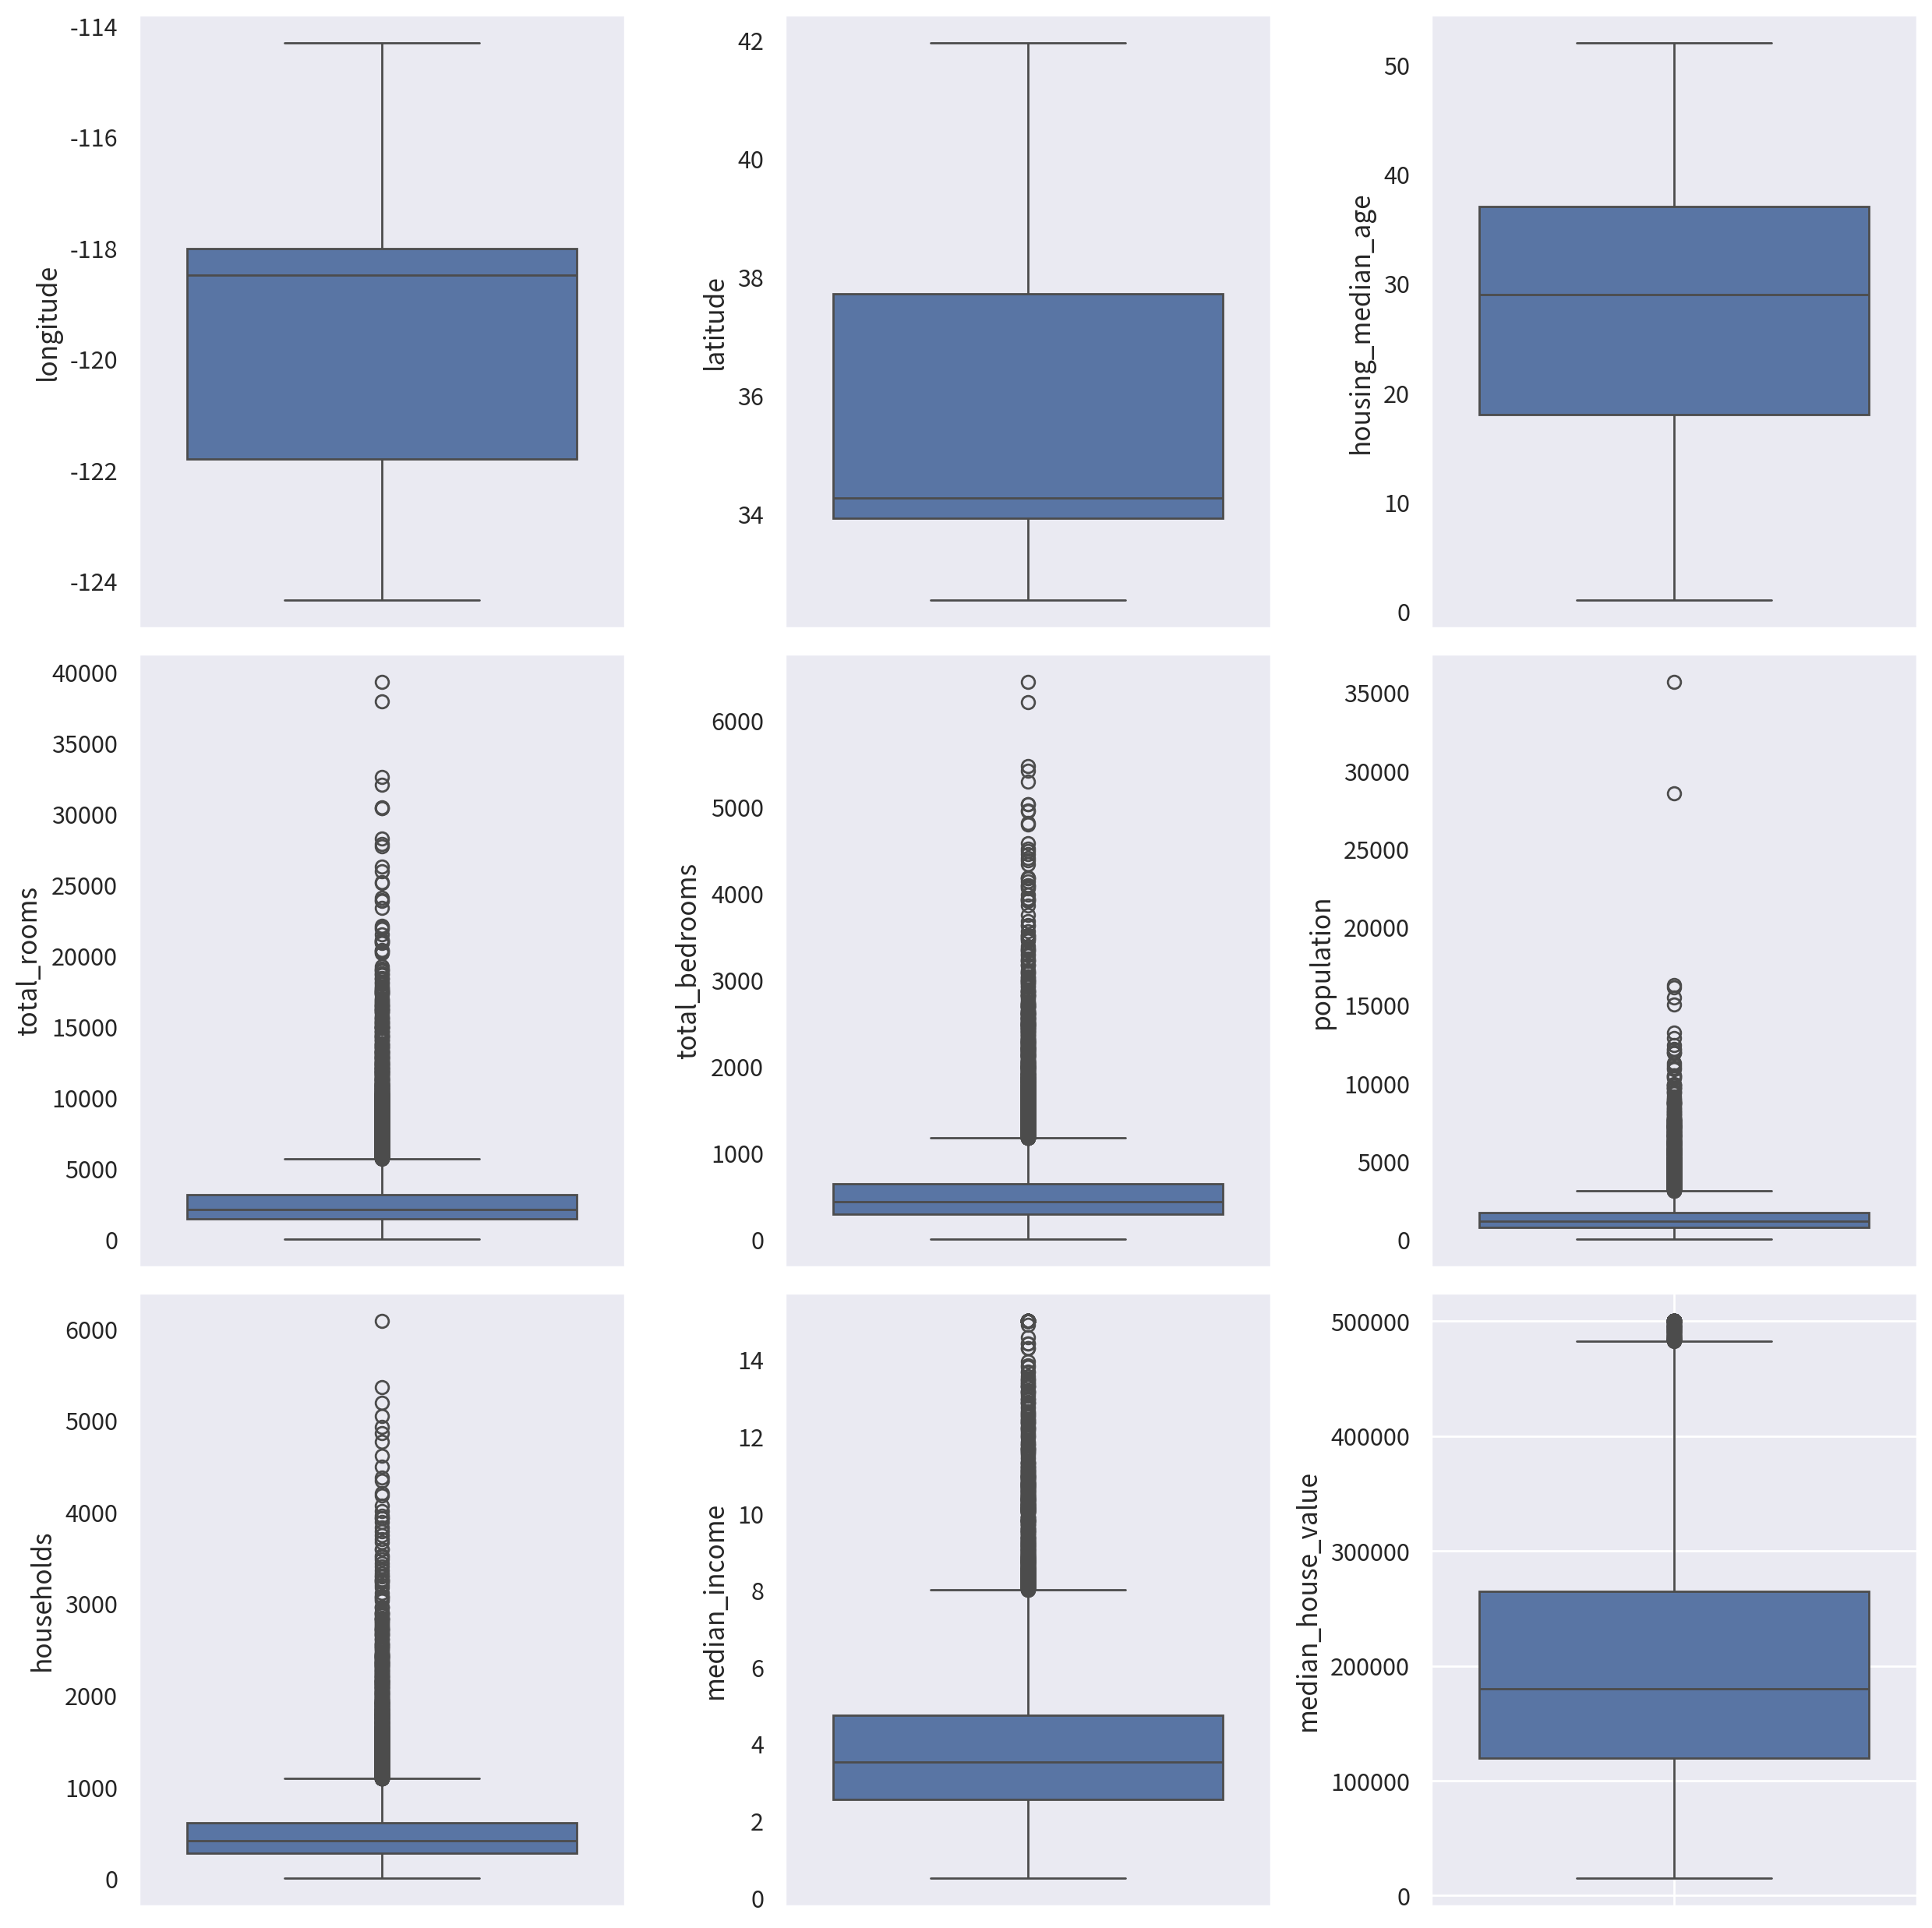

In [7]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 2500             #그래프 가로 크기
height_px = 2500             #그래프 세로 크기
rows = 3                    #도화지의 행 수
cols = 3                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.boxplot(data=origin['longitude'],orient='v',ax=ax[0][0])
sb.boxplot(data=origin['latitude'],orient='v',ax=ax[0][1])
sb.boxplot(data=origin['housing_median_age'],orient='v',ax=ax[0][2])
sb.boxplot(data=origin['total_rooms'],orient='v',ax=ax[1][0])
sb.boxplot(data=origin['total_bedrooms'],orient='v',ax=ax[1][1])
sb.boxplot(data=origin['population'],orient='v',ax=ax[1][2])
sb.boxplot(data=origin['households'],orient='v',ax=ax[2][0])
sb.boxplot(data=origin['median_income'],orient='v',ax=ax[2][1])
sb.boxplot(data=origin['median_house_value'],orient='v',ax=ax[2][2])

# 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용
plt.grid(True)

# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

0인 값은 없으며 변수의 범위가 **구역 내** 이므로 이상치가 존재하지만 현실적인 범위라고 생각됨.

1940년 이전 건축 주택이 52로 코딩되는 이유

In [8]:
print(origin['housing_median_age'].describe())
#origin['housing_median_age']값이 52인 것의 개수 출력
origin[origin['housing_median_age'] == 52].shape[0]

count    20640.000000
mean        28.639486
std         12.585558
min          1.000000
25%         18.000000
50%         29.000000
75%         37.000000
max         52.000000
Name: housing_median_age, dtype: float64


1273

- 데이터를 수집하는 단계에서 1940년 이전의 데이터가 없었기 때문에 그 때 당시의 시간 값을 뺀 느낌
- 데이터 총 건수 20640개 중 52에 해당하는 데이터가 1273개 = 전체 데이터 중 6% 해당하는 데이터라 채워 넣어도 상관 없을 것 같다고 판단하여 52로 채워넣은듯.
- 분석에는 1940년전 건물로 분석이 될 것임. 극단적으로 1940년전이 많이 나오진 않을듯

- 필요한 전처리는 total_bedrooms의 결측치인 207개 값을 삭제하는 것
    - 삭제의 근거는 총 데이터 20640개중 1% 정도 되는 것으로 확인하여 삭제해도 상관 없을 거 같다는 생각이 듦


In [9]:
# total_bedrooms 결측치 제거
df = origin.copy()
df = df.dropna(subset=['total_bedrooms'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  int64  
 3   total_rooms         20433 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  int64  
 6   households          20433 non-null  int64  
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  int64  
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(4), int64(5), object(1)
memory usage: 1.7+ MB


- 삭제하기 전 원본 데이터 개수 20640
    - 삭제 후 데이터 개수 20433 , 207개 제거 완료

In [10]:
df['median_house_value'].describe()

count     20433.000000
mean     206864.413155
std      115435.667099
min       14999.000000
25%      119500.000000
50%      179700.000000
75%      264700.000000
max      500001.000000
Name: median_house_value, dtype: float64

- 50만 달러 현 시세로 7억 4천만원 가량
    - 현실성 매우 있음

### 미션 2. 가격과 핵심 변수의 첫인상
- 1. MedHouseValue, Medlnc, HouseAge, AveRooms 분포를 히스토그램/KDE로 확인하고 알 수 있는 객관적 사실을 서술한다.
- 2. 왜도/이상치가 회귀에 줄 수 있는 영향과 변환할 필요가 있는지 서술하시오.
- 3. 분포 비교는 동일 축 스케일로 제시하고, 평균/중앙값/꼬리의 차이를 문장으로 요약하세요.
- 4. 지역별(Latitude/Longitude)편향이나 시계열 문제(1990년 데이터만)가 해석에 미치는 영향도 짧게 언급하세요.

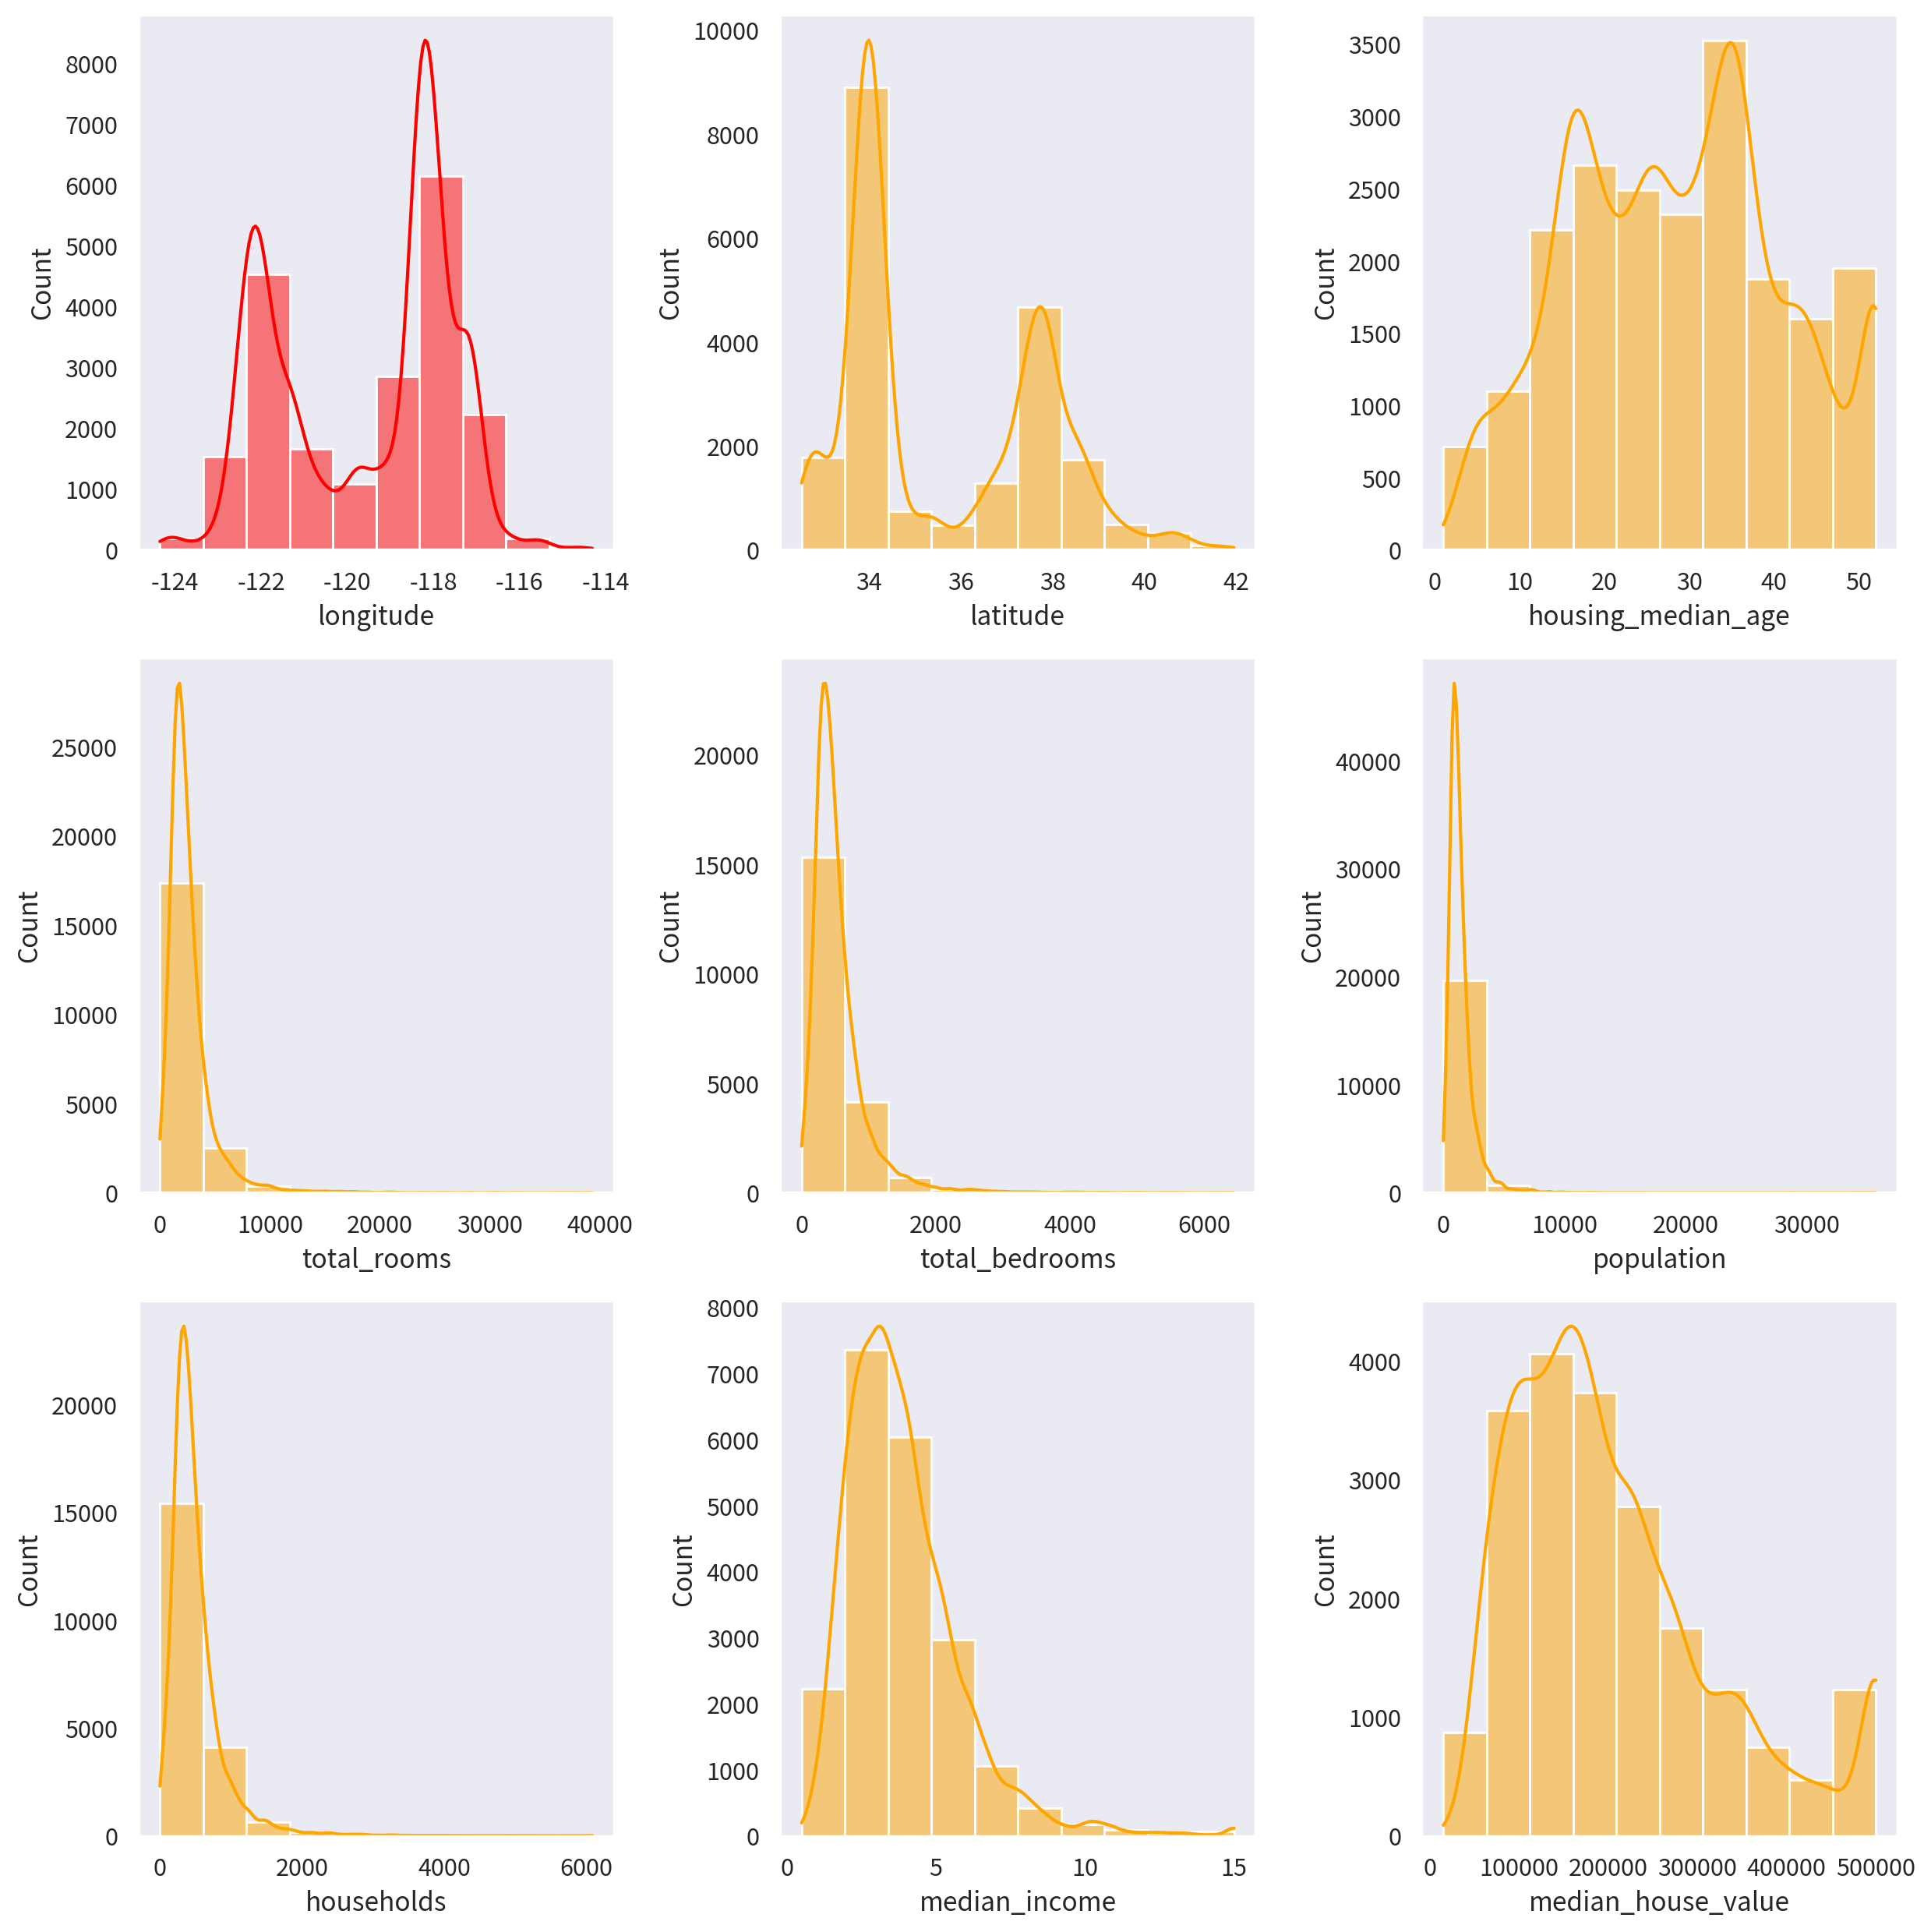

In [11]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 2500             #그래프 가로 크기
height_px = 2500             #그래프 세로 크기
rows = 3                    #도화지의 행 수
cols = 3                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.histplot(data=df, x='longitude', bins=10, kde=True, color='red', ax=ax[0,0])
sb.histplot(data=df, x='latitude', bins=10, kde=True, color='orange', ax=ax[0,1])
sb.histplot(data=df, x='housing_median_age', bins=10, kde=True, color='orange', ax=ax[0,2])
sb.histplot(data=df, x='total_rooms', bins=10, kde=True, color='orange', ax=ax[1,0])
sb.histplot(data=df, x='total_bedrooms', bins=10, kde=True, color='orange', ax=ax[1,1])
sb.histplot(data=df, x='population', bins=10, kde=True, color='orange',ax=ax[1,2])
sb.histplot(data=df, x='households', bins=10, kde=True, color='orange',ax=ax[2,0])
sb.histplot(data=df, x='median_income', bins=10, kde=True, color='orange',ax=ax[2,1])
sb.histplot(data=df, x='median_house_value', bins=10, kde=True, color='orange',ax=ax[2,2])

# 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용


# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

- 34, 38, -122, -118 부근에 구역이 많이 위치하고 있다.
- 구역의 집의 나이 중앙값은 10년 미만의 값이 거의 없다 (1000건대)
    - 신축이라고 볼 수 있는 집이 거의 없음
- 구역의 방 개수, 침실 개수, 인구수, 가구수는 그래프 상 왼쪽에 치우쳐져 있다.
- median_income 과 median_house_value는 왼쪽으로 치우쳐진 정규분포를 띄고 있다.

In [23]:
df2 = df.drop(columns='ocean_proximity')
# 왜도 계산
df2_skewness = df2.skew().sort_values(ascending=False)
# print(df2_skewness)
df2_nan = df2.isna().sum()
# print(df2_nan)
# 왜도가 1 이상이면 추출
im_skew = df2_skewness[abs(df2_skewness) > 1]
print("왜도가 심한 변수:", im_skew)
print("결측치 개수:\n",df2_nan)

왜도가 심한 변수: population        4.960017
total_rooms       4.158816
total_bedrooms    3.459546
households        3.413850
median_income     1.644557
dtype: float64
결측치 개수:
 longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64


- 왜도가 심하면 극단적인 값이 존재한다는 것인데 (한쪽으로 치우침), 정규분포를 따르지 않는다는 것이고 예측에 대해 부정확해짐
- 데이터 건수가 많기 때문에 따른다고 가정하고 해도 될 것 같은데..
- 왜도가 심한 변수는 다른 변수들과의 선형 관계를 파악하기 어렵게 만듦
    - 이러한 변수들은 종속 변수에 더 중요한 영향을 미치는지 판단하는 오즈비 해석의 신뢰도를 떨어뜨림
- 실제 캘리포니아의 주거 특징이라면 왜도를 바꾸지 않고 진행해도 될 듯함
    - 하지만 모델의 성능 차이가 심할 수 있음
    - 로그 변환한 데이터와 변환하지 않은 데이터를 가지고 AUC 성능 비교를 해보면 될 듯 함

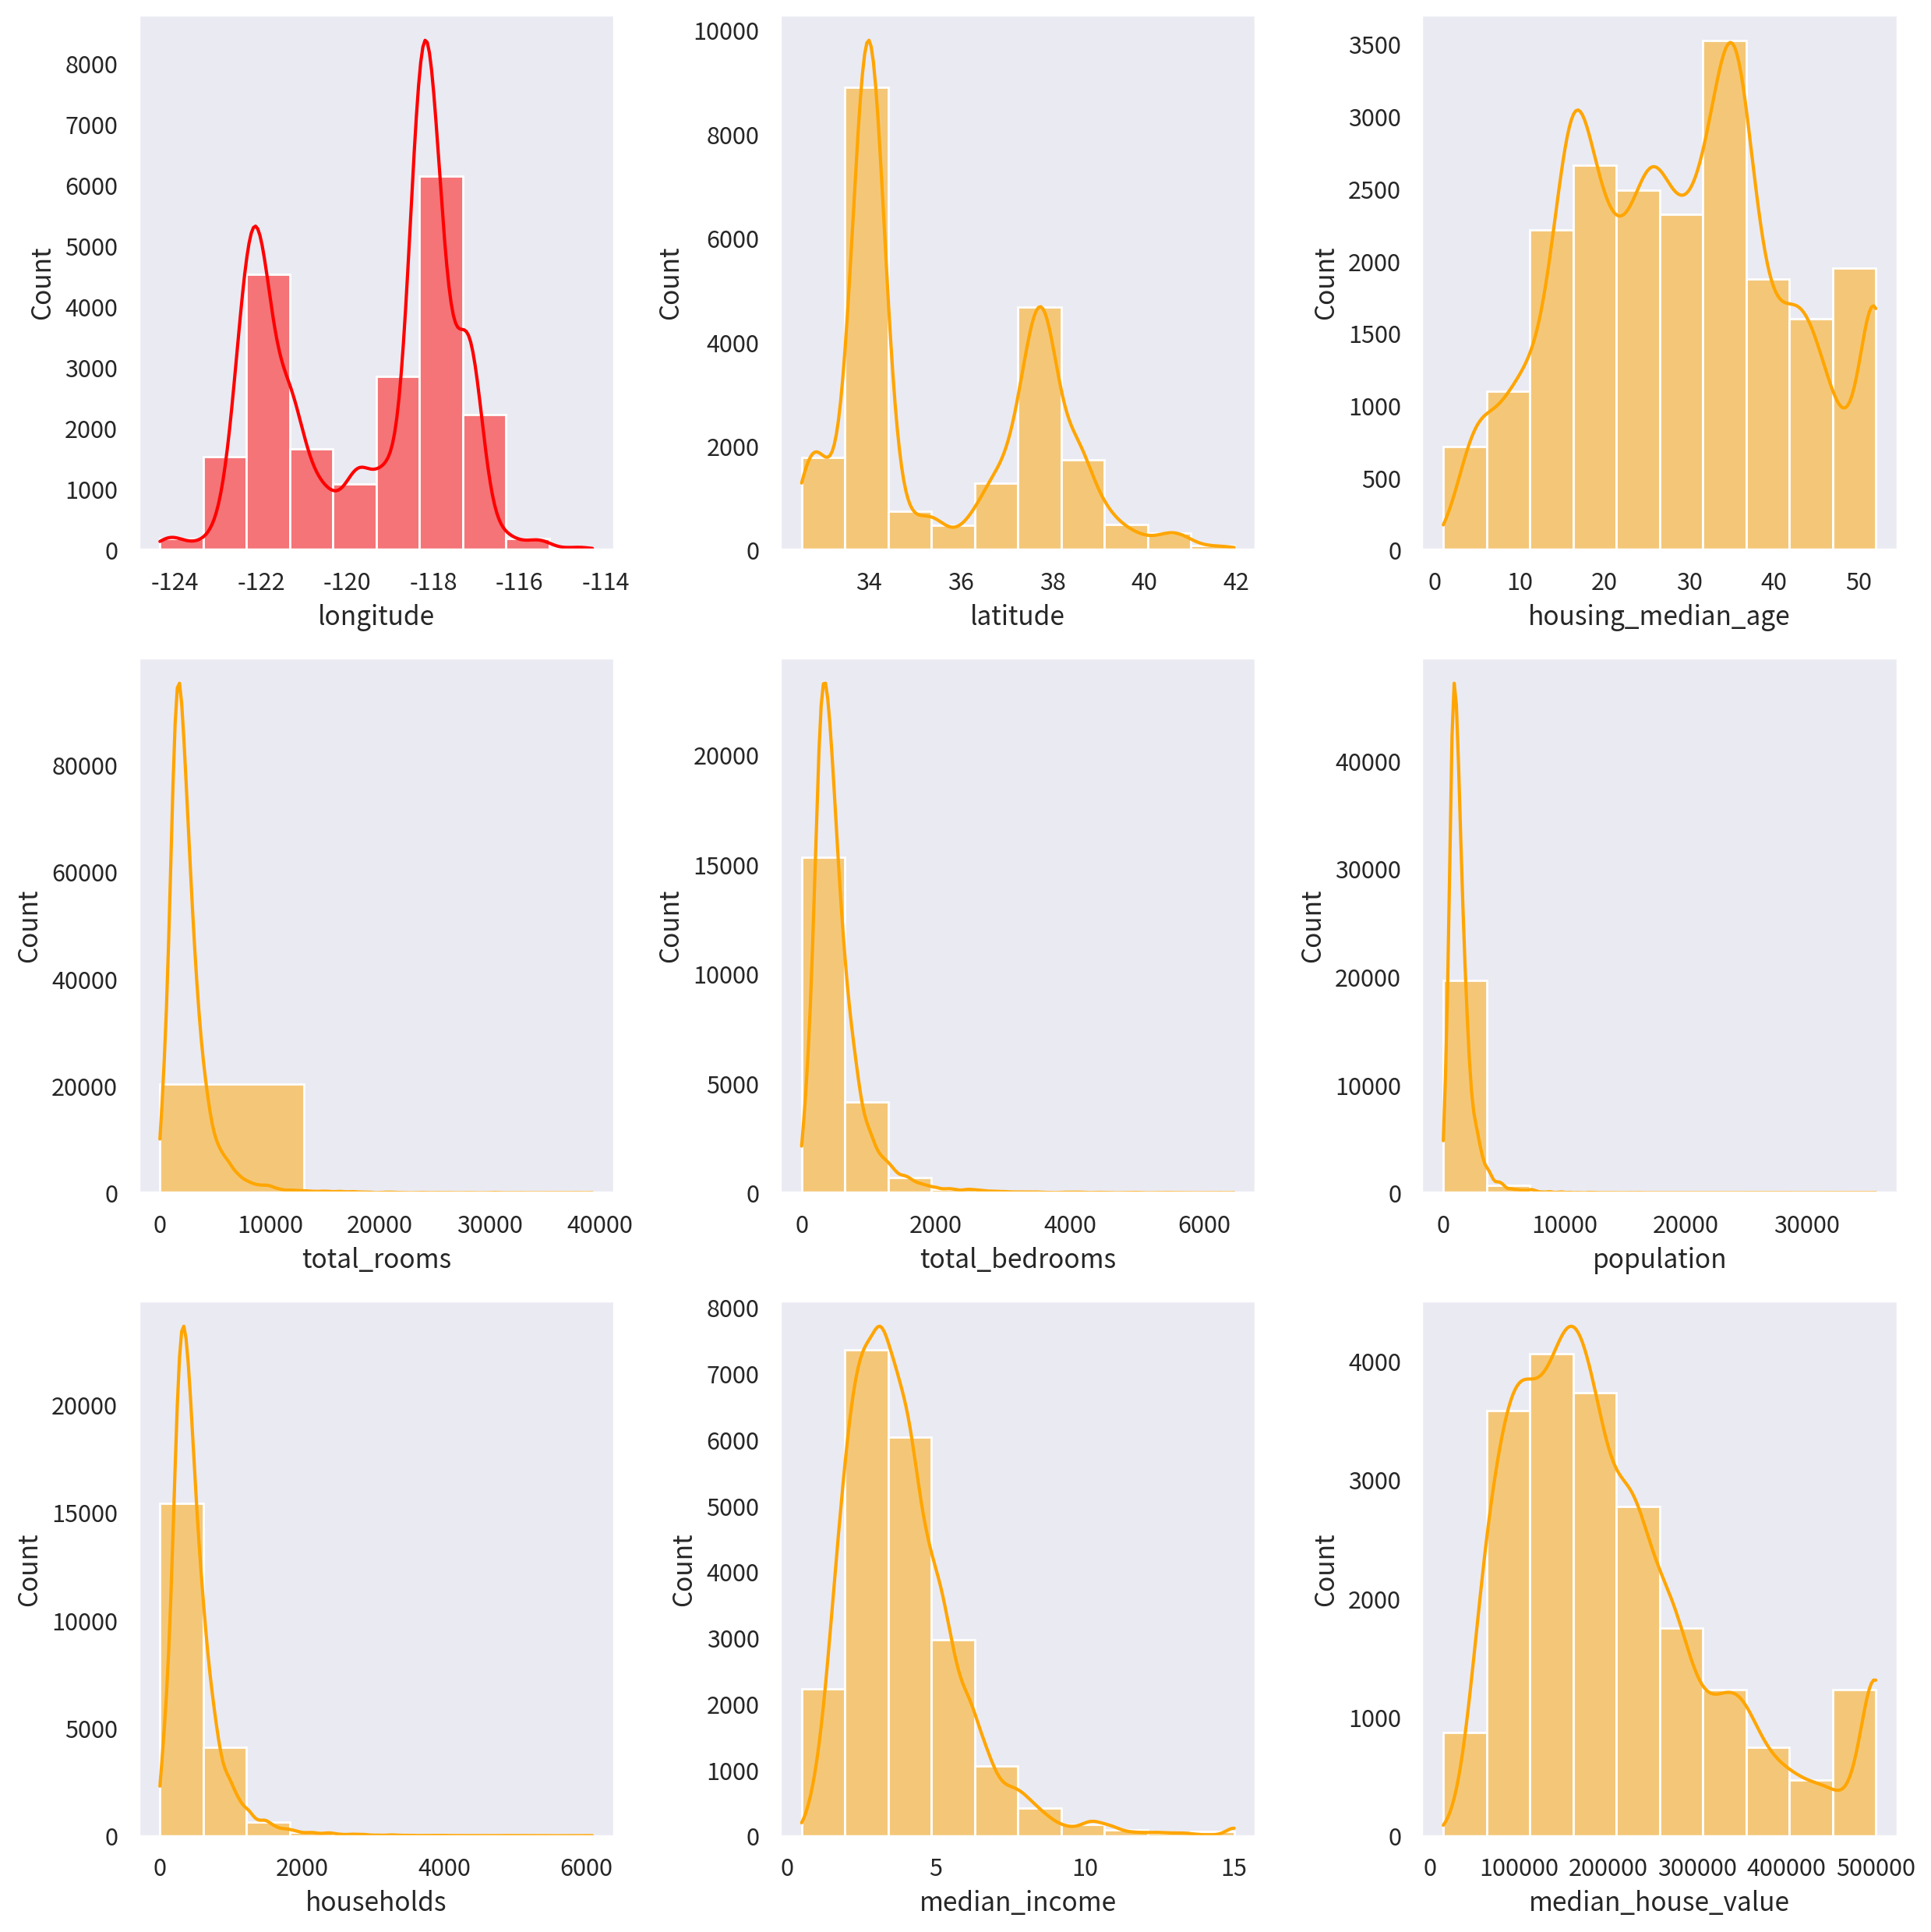

In [45]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 2500             #그래프 가로 크기
height_px = 2500             #그래프 세로 크기
rows = 3                    #도화지의 행 수
cols = 3                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.histplot(data=df, x='longitude', bins=10, kde=True, color='red', ax=ax[0,0])
sb.histplot(data=df, x='latitude', bins=10, kde=True, color='orange', ax=ax[0,1])
sb.histplot(data=df, x='housing_median_age', bins=10, kde=True, color='orange', ax=ax[0,2])
sb.histplot(data=df, x='total_rooms', bins=3, kde=True, color='orange', ax=ax[1,0])
sb.histplot(data=df, x='total_bedrooms', bins=10, kde=True, color='orange', ax=ax[1,1])
sb.histplot(data=df, x='population', bins=10, kde=True, color='orange',ax=ax[1,2])
sb.histplot(data=df, x='households', bins=10, kde=True, color='orange',ax=ax[2,0])
sb.histplot(data=df, x='median_income', bins=10, kde=True, color='orange',ax=ax[2,1])
sb.histplot(data=df, x='median_house_value', bins=10, kde=True, color='orange',ax=ax[2,2])

# 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용


# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

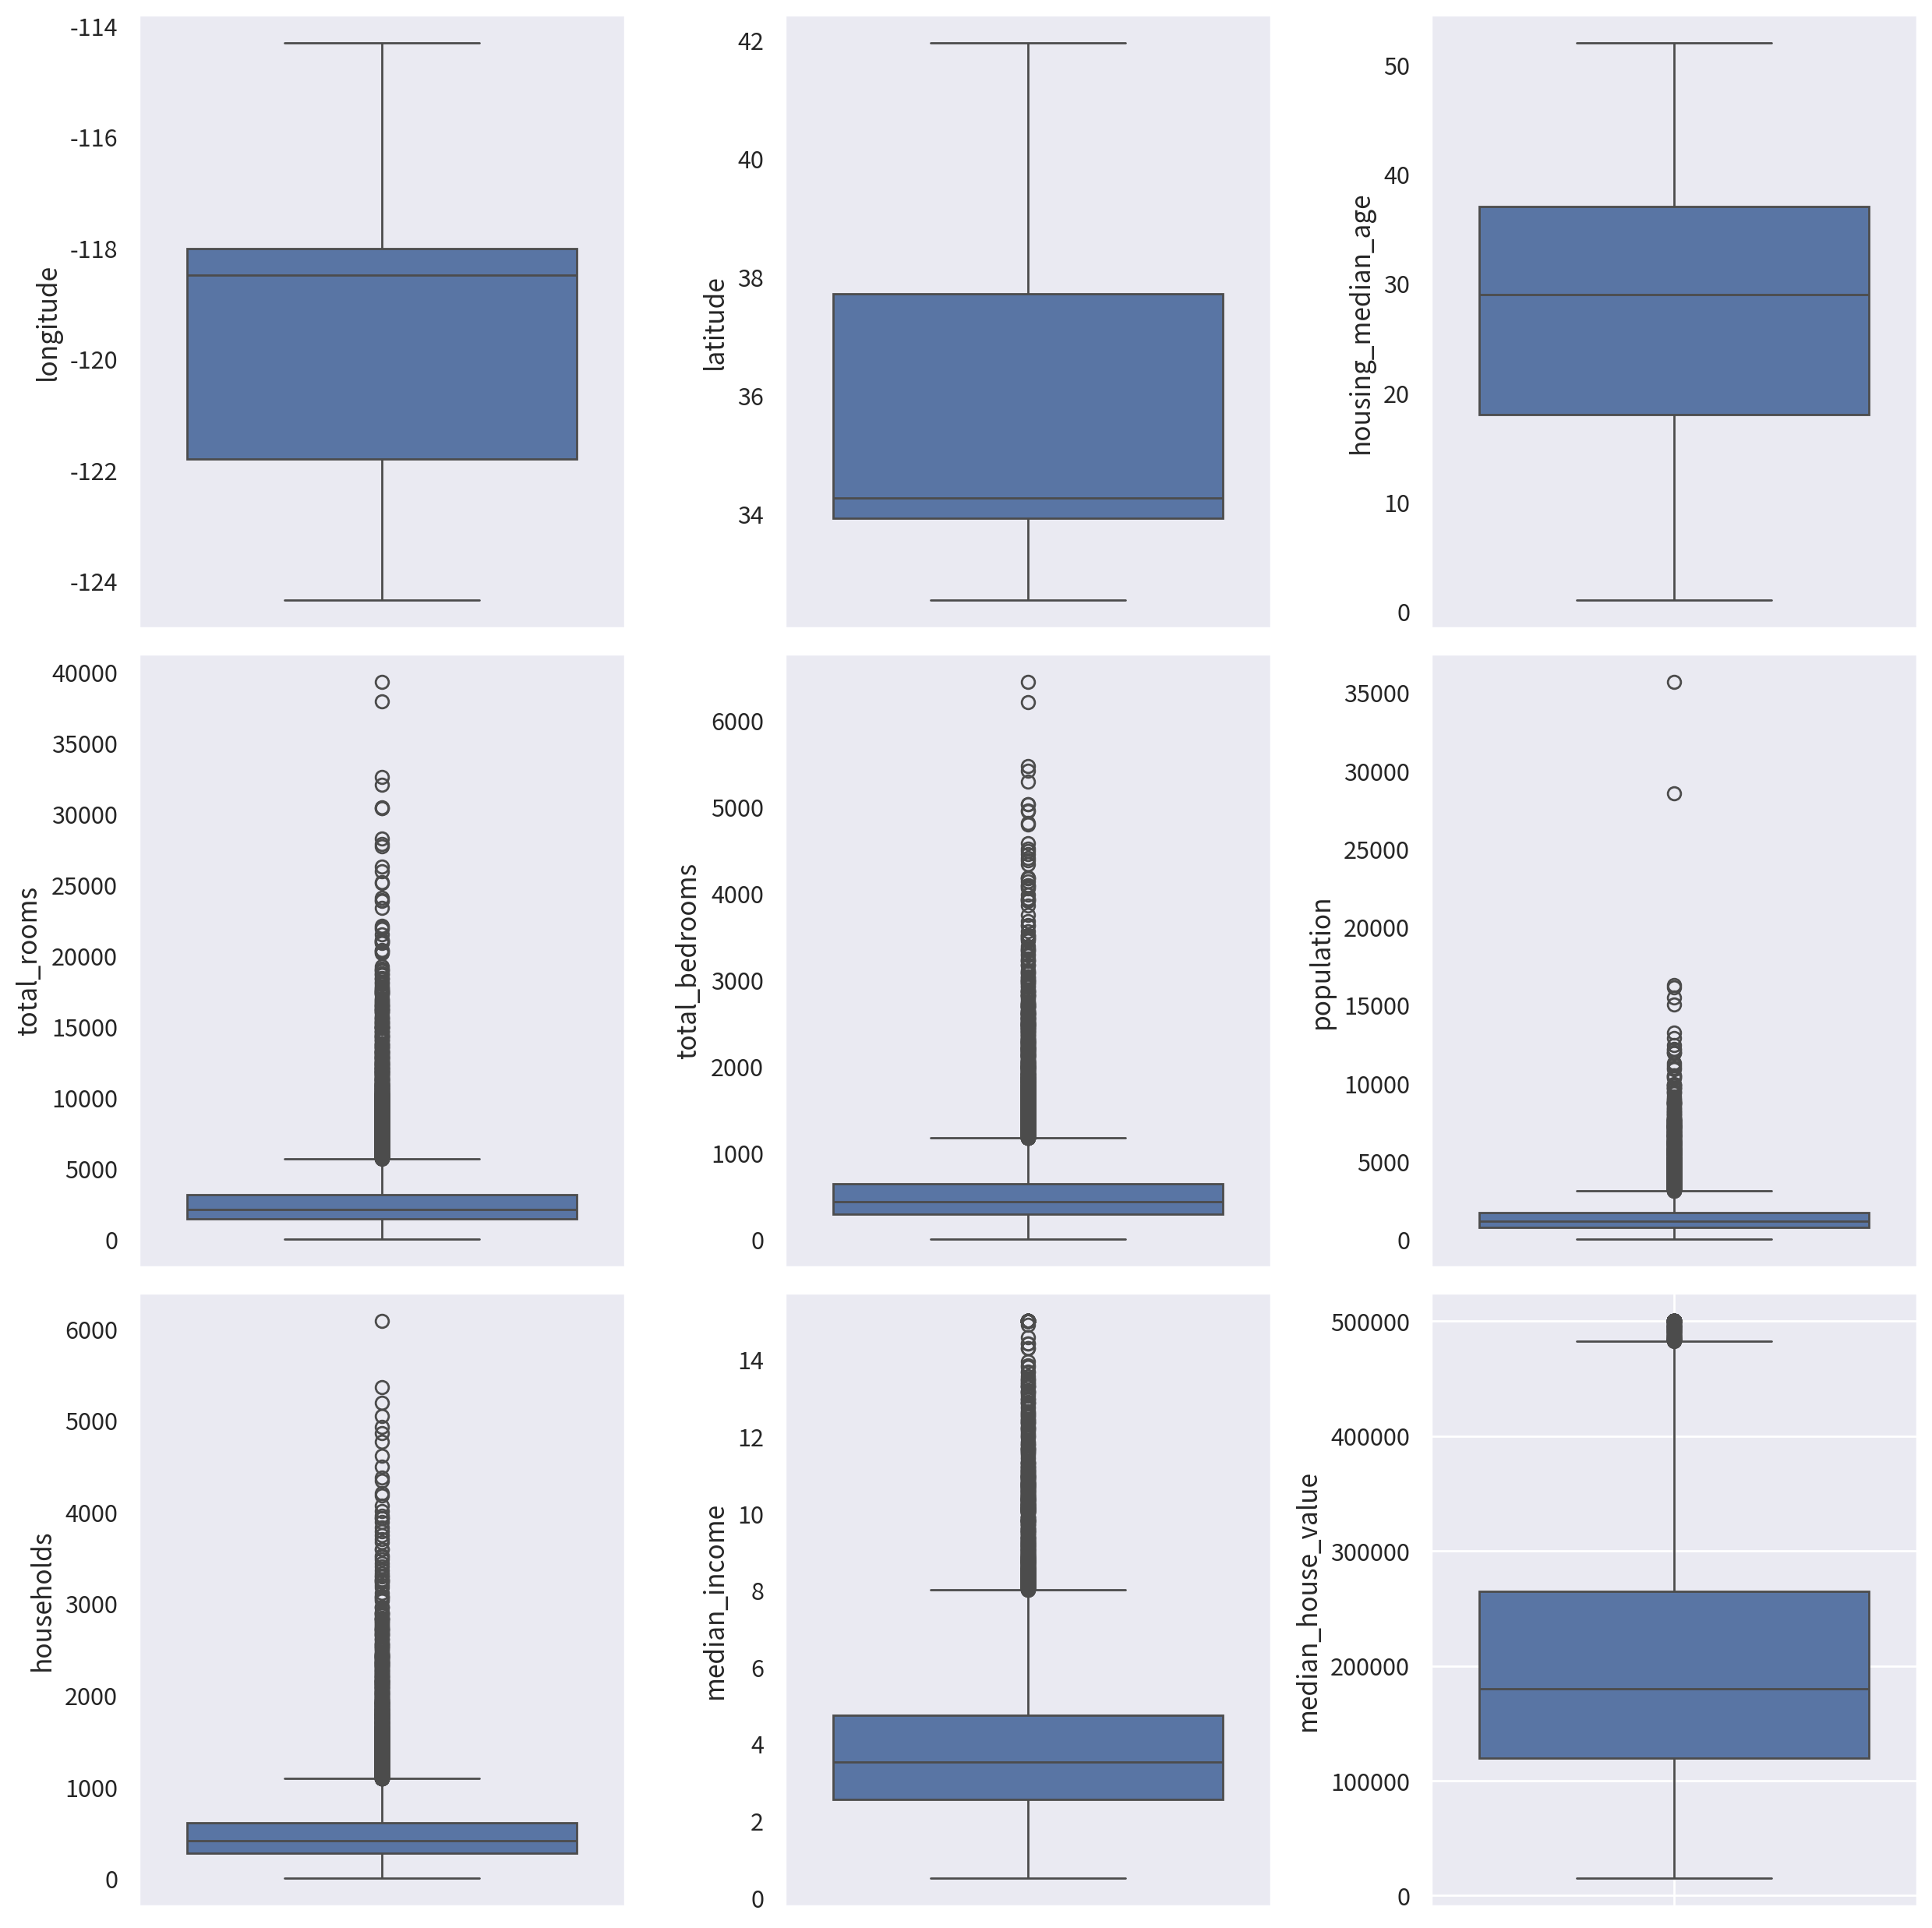

In [16]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 2500             #그래프 가로 크기
height_px = 2500             #그래프 세로 크기
rows = 3                    #도화지의 행 수
cols = 3                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.boxplot(data=origin['longitude'],orient='v',ax=ax[0][0])
sb.boxplot(data=origin['latitude'],orient='v',ax=ax[0][1])
sb.boxplot(data=origin['housing_median_age'],orient='v',ax=ax[0][2])
sb.boxplot(data=origin['total_rooms'],orient='v',ax=ax[1][0])
sb.boxplot(data=origin['total_bedrooms'],orient='v',ax=ax[1][1])
sb.boxplot(data=origin['population'],orient='v',ax=ax[1][2])
sb.boxplot(data=origin['households'],orient='v',ax=ax[2][0])
sb.boxplot(data=origin['median_income'],orient='v',ax=ax[2][1])
sb.boxplot(data=origin['median_house_value'],orient='v',ax=ax[2][2])

# 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용
plt.grid(True)

# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

- 위에서 그린 표와 같은 표
    - longitude, housing_median_age를 제외하고 나머지 변수들이 왼쪽으로 치우쳐져 있는 경향을 보임
    - 전반적으로 평균보다 왼쪽에 중앙값이 위치하여 꼬리가 오른쪽으로 나있는 형태
    - 지역 간 데이터 건수가 다르기 때문에 영향이 있을 것이다.

### 미션 3. 로그/비선형 변환을 고민해보자.
- 1. MedHouseValue 혹은 주요 변수 (Medlnc, Population, HouseAge)에 로그/제곱근 등 변환을 적용해 전 후 분포를 나란히 비교한다.
- 2. 변환이 해석과 모델 적합에 주는 장단점, 해석이 어떻게 달라지는지 예상한다.
- 3. 이 변환이 없으면 어떤 함정에 빠질까? 를 한 줄로 정리한다.
- 4. 선택 기준을 명시하세요: 왜 log(MedHouseValue)인지, 왜 Population에 로그인지 등 데이터 분포 근거로 설명합니다.
- 5. 필요한 경우 Box-Cox 등의 변환을 비교해 가장 해석 친화적인 옵션을 선택하세요.

In [31]:
df2_log = df2.copy()
# 1. MedHouseValue, Medlnc, Population, HouseAge 변수에 로그 변환 후 다시 계산
df2_log['median_income'] = np.log1p(df2['median_income'])
df2_log['population'] = np.log1p(df2['population'])
df2_log['total_rooms'] = np.log1p(df2['total_rooms'])
df2_log['total_bedrooms'] = np.log1p(df2['total_bedrooms'])
df2_log['households'] = np.log1p(df2['households'])
df2_log_skewness = df2_log.skew().sort_values(ascending=False)
print("로그 변환 후 왜도:\n", df2_log_skewness)

로그 변환 후 왜도:
 median_house_value    0.978290
latitude              0.464934
median_income         0.224597
housing_median_age    0.061605
longitude            -0.296141
total_bedrooms       -0.992813
population           -1.048037
households           -1.056801
total_rooms          -1.081242
dtype: float64


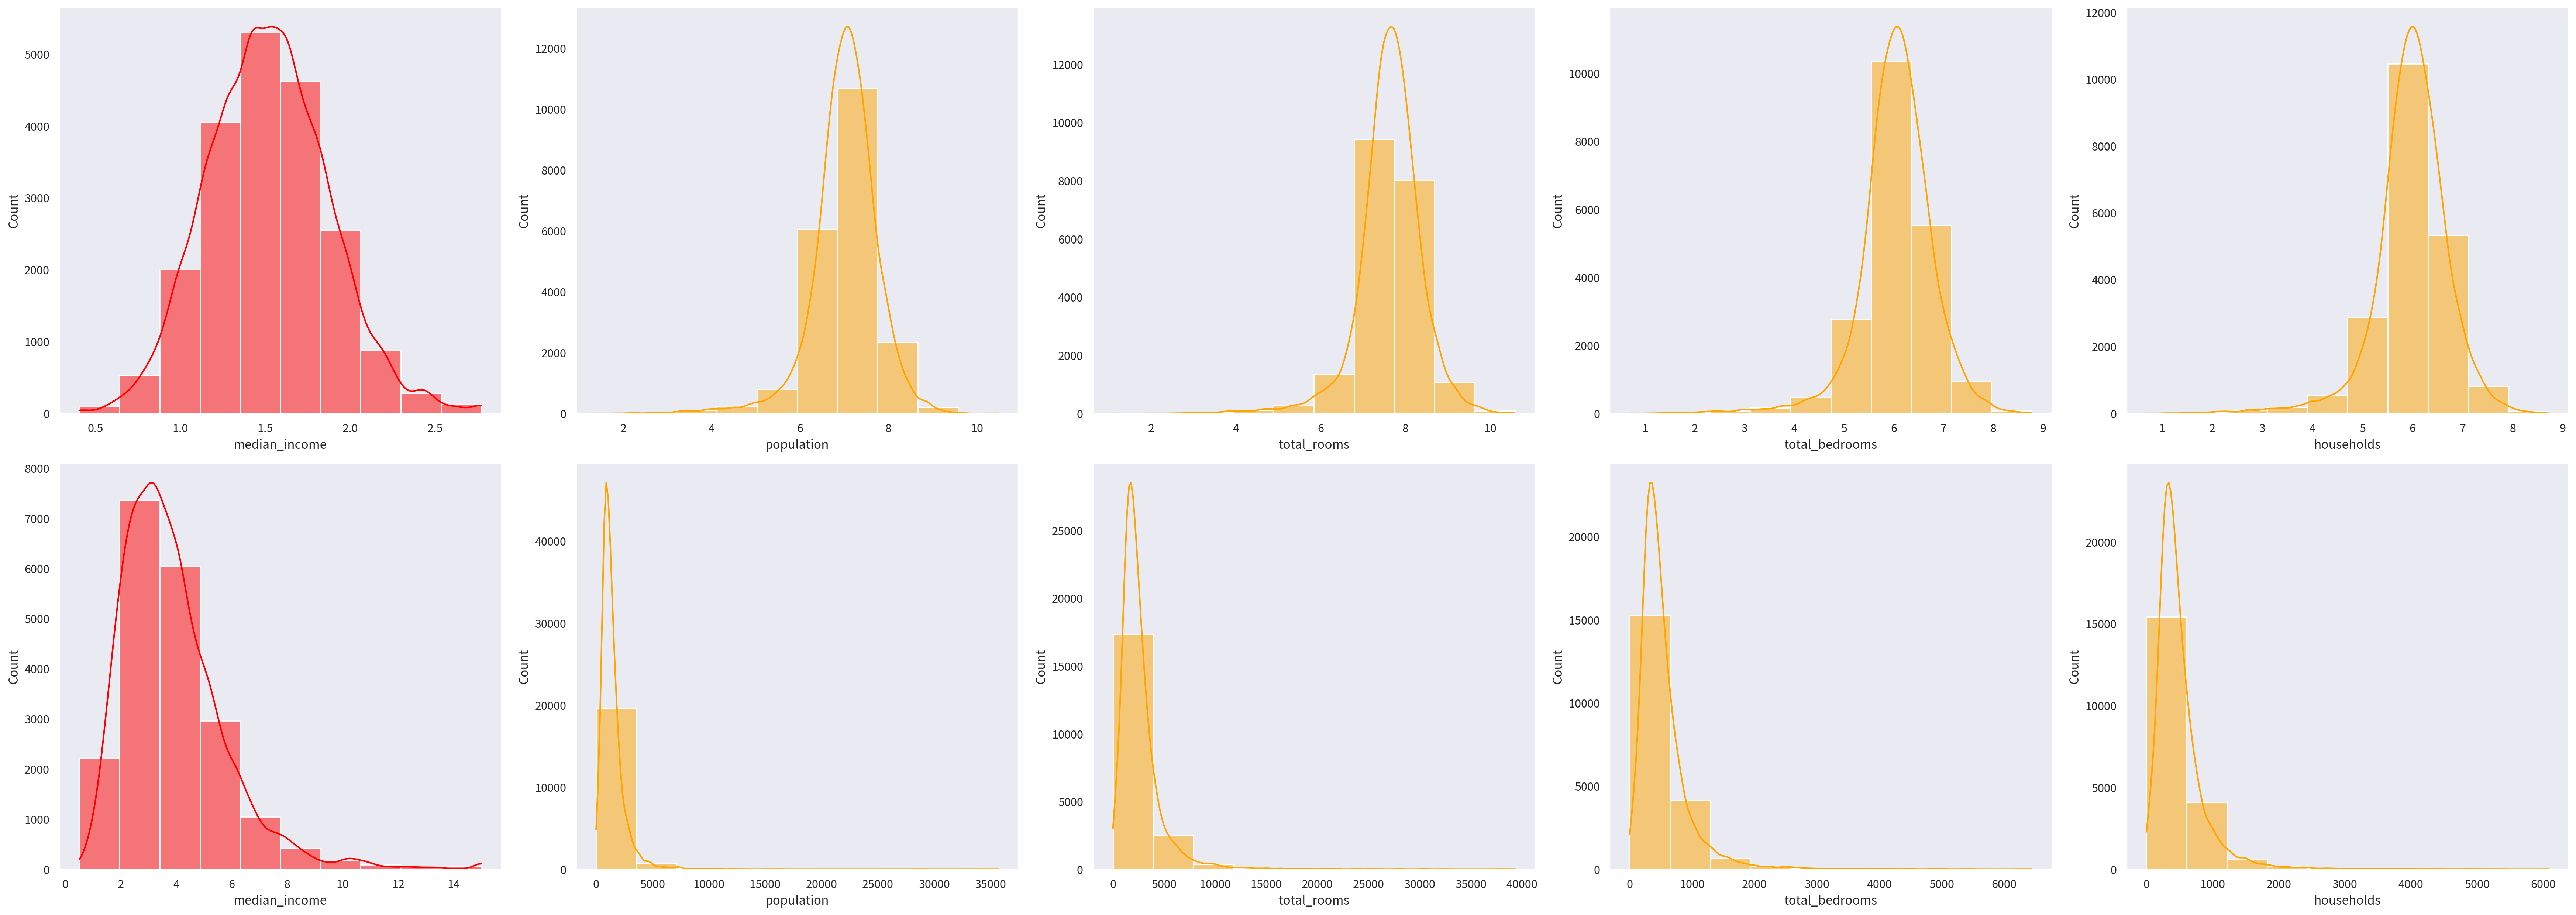

In [34]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 7000             #그래프 가로 크기
height_px = 2500             #그래프 세로 크기
rows = 2                    #도화지의 행 수
cols = 5                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.histplot(data=df2_log, x='median_income', bins=10, kde=True, color='red', ax=ax[0,0])
sb.histplot(data=df2_log, x='population', bins=10, kde=True, color='orange', ax=ax[0,1])
sb.histplot(data=df2_log, x='total_rooms', bins=10, kde=True, color='orange', ax=ax[0,2])
sb.histplot(data=df2_log, x='total_bedrooms', bins=10, kde=True, color='orange', ax=ax[0,3])
sb.histplot(data=df2_log, x='households', bins=10, kde=True, color='orange', ax=ax[0,4])
sb.histplot(data=df2, x='median_income', bins=10, kde=True, color='red', ax=ax[1,0])
sb.histplot(data=df2, x='population', bins=10, kde=True, color='orange', ax=ax[1,1])
sb.histplot(data=df2, x='total_rooms', bins=10, kde=True, color='orange', ax=ax[1,2])
sb.histplot(data=df2, x='total_bedrooms', bins=10, kde=True, color='orange', ax=ax[1,3])
sb.histplot(data=df2, x='households', bins=10, kde=True, color='orange', ax=ax[1,4])

# 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용


# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

- 분포가 변환하기 전보다 한쪽으로 치우지지 않게끔 처리됨
    - 밑이 변환하기 전, 위가 변환 후의 모습
    - 정규 분포에 가깝게 만들어줌 => 모델이 안정적인 결과를 도출해낼 확률이 올라감
    - 변환하기 전이라면 극단적인 값이 많기 때문에 해당 값들의 영향력이 셀 것..
- log를 취한 변수들의 기준
    - 분포 상 한쪽으로 치우침이 많은 변수들을 선정
    - 선정되지 않은 변수들은 위 경도의 경우는 실제 위치이기 때문에 변환하지 않아도 된다고 생각
    - 나머지 변수들은 다른 변수들의 비해 왜도가 심하지 않았기에 변환하지 않음.

### 미션 4. 지리적 위치는 정말 중요할까?
- 1. 위도와 경도를 활용한 지리적 시각화를 수행한다.
- 2. 산점도(경도 X 위도, 점의 색상 = MedHouseValue)를 그려 주택 가격의 지리적 불평등을 관찰한다.
- 3. 어느 지역이 비싼가?, 가격 차이가 얼마나 뚜렷한가? 를 데이터 기반으로 설명하세요.
- 4. 위도/경도가 개별 변수보다 지역 표상(Proxy)이라는 점을 인식하고 이것이 회귀에 주는 의미를 논의하세요.

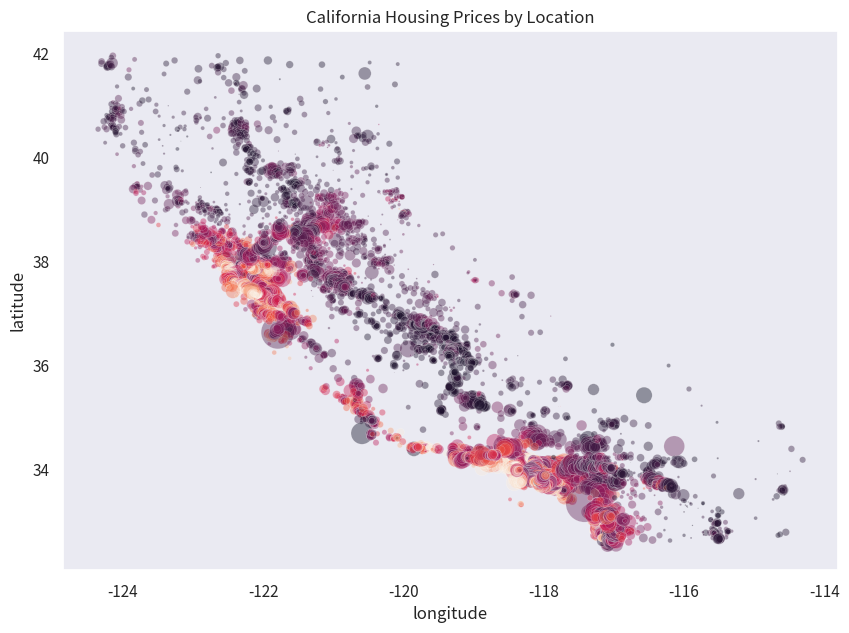

In [52]:
plt.figure(figsize=(10, 7))
# s: 점의 크기(인구수 비례), c: 색상(주택 가격 비례)
sb.scatterplot(data=origin, x='longitude', y='latitude', 
                alpha=0.4, s=origin['population']/50, 
                c=origin['median_house_value'])
plt.title('California Housing Prices by Location')
plt.show()